In [1]:
 #12 de Marzo de 2019

library(mdatools)
library(devtools)
library(BiocManager)
#BiocManager::install("pcaMethods", version= "3.8")
library(pcaMethods)
#devtools::install_github('kimsche/MetaboMate', build_vignettes=TRUE)
library(MetaboMate)
#devtools::install_github('jwist/visualizeR')
library(car)


Warning message:
"package 'mdatools' was built under R version 3.5.3"Warning message:
"package 'usethis' was built under R version 3.5.3"Warning message:
"package 'BiocManager' was built under R version 3.5.2"
Attaching package: 'BiocManager'

The following object is masked from 'package:devtools':

    install

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, gr

In [2]:
#Importing data from Github
Metadata <-read.csv('https://raw.githubusercontent.com/davidgarciam/propolis_project/master/Propolis_data/Propoleo_metadata.csv', header= TRUE, sep= ";")
dim(Metadata)
head(Metadata)

[1] 123  17

SampleID,SampleNMR,Date_YMD,Probe,Shims,RG,Type,Folder,Origen,Zona,Type2,Color,R,G,B,Extracto,Resinas..
M46,PRO046B_PRO,190205,2,,64,,32,Santander,bh-PM,2,red,115,2,0,"5,48",ND
M47,PRO047A_PRO,190205,2,,"50,8",,32,Santander,bh-PM,2,reddish_yellow,246,99,1,"4,23",65
M47,PRO047B_PRO,190205,2,,"45,2",,32,Santander,bh-PM,2,reddish_yellow,246,99,1,"4,23",65
M48,PRO048A_PRO,190118,2,,"60,5",,32,Casanare,bh-T,2,yellow,162,133,54,"7,74",14
M25,PRO025A_PRO,180917,1,,"90,5",,22,Tolima,bh-T,2,light_yellow,108,102,68,"3,58",0
M44,PRO044A_C,190206,2,,64,C,22,Brasil,BRA,1,red,115,2,0,"11,51",ND


In [3]:
part1 <- read.csv('https://raw.githubusercontent.com/davidgarciam/propolis_project/master/Propolis_data/part1d.csv', header= T, sep= ",")
dim(part1)
part2 <- read.csv('https://raw.githubusercontent.com/davidgarciam/propolis_project/master/Propolis_data/part2d.csv', header= T, sep= ",")
dim(part2)

[1] 131072     60

[1] 131072     63

In [4]:
X <- cbind(part1, part2)
dim(X)
colnames(X) <- seq_along(X[1,])

[1] 131072    123

In [5]:
ppm <- read.csv('https://raw.githubusercontent.com/davidgarciam/propolis_project/master/Propolis_data/ppmpro_all_center.csv', header= FALSE)

In [6]:
a_intensity <- t(X)
ppm <- t(ppm)

dim(a_intensity)
dim(Metadata)
dim(ppm)

[1]    123 131072

[1] 123  17

[1]      1 131072

# Data pre-processing

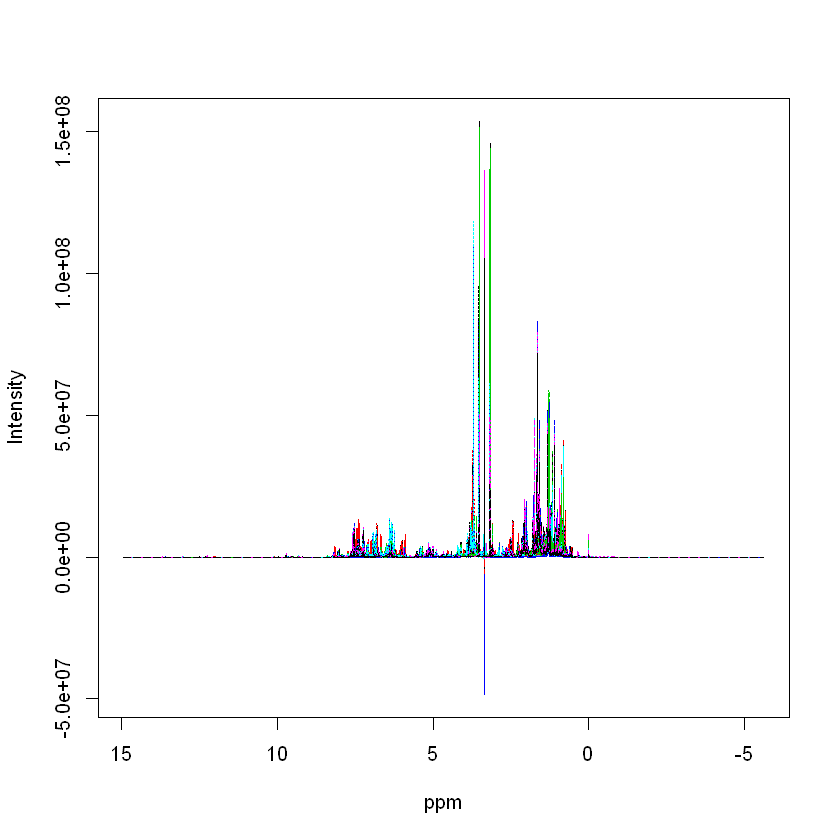

In [7]:
#Bad shimming 
X <- a_intensity[c(-22, -25, -33, -36, -104, -112, -113, -119),]#Eliminar espectros con shims malos
Metadata_f <- Metadata[c(-22, -25, -33, -36, -104, -112, -113, -119),]#Eliminar espectros con shims malos
ColorRGB <- data.frame(Metadata_f$SampleNMR, Metadata_f$R, Metadata_f$G, Metadata_f$B)

matspec(ppm, X, shift= range(ppm))

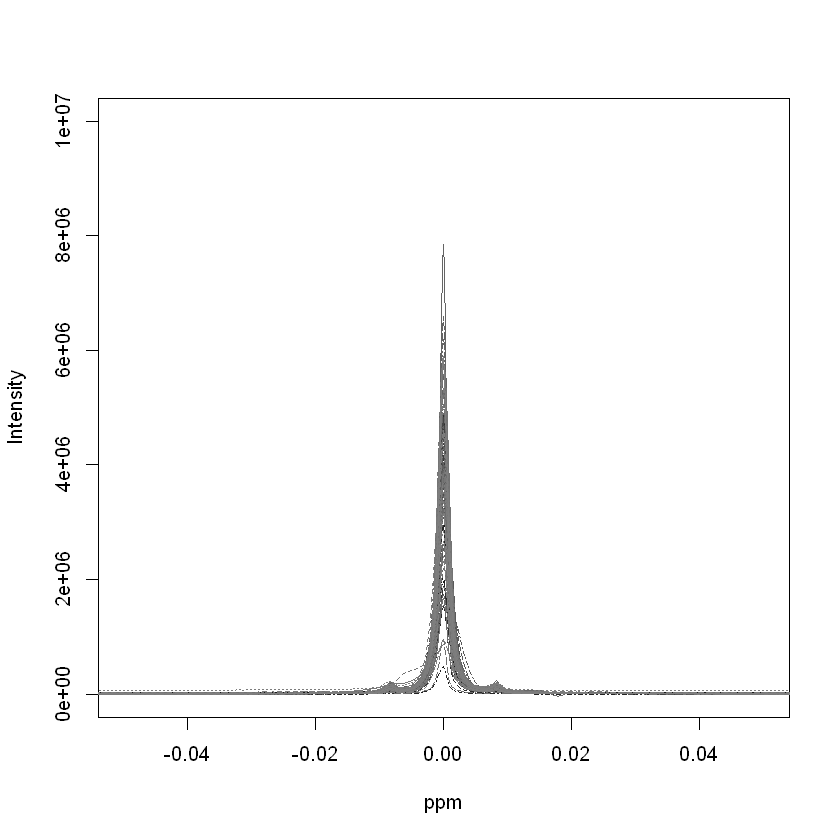

In [8]:
#Spectra Calibration
X.cali=calibration(X, ppm, type='Urine')
        
#Visualization
Gray <- gray.colors(115, start=0.1, end=0.5, gamma=2.2, alpha=NULL)

matplot(t(ppm),t(X.cali), type=("l"), xlim = c(-0.05,0.05), ylim=c(-1e4, 1e7), xlab="ppm", ylab="Intensity", col=Gray)


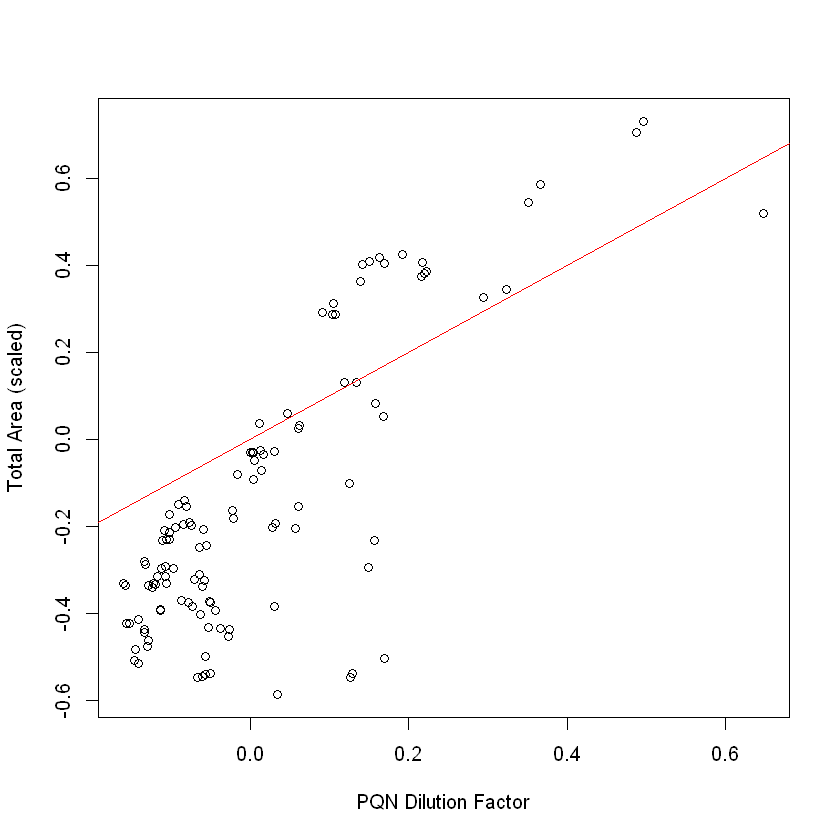

In [9]:
#Indexing of chemical shifts regions

idx.TMS= get.idx(range=c(min(ppm),0.5), ppm)
idx.meoh1= get.idx(range=c(3.15,3.29), ppm)
idx.meoh2= get.idx(range=c(3.32,3.38), ppm)
idx.meoh3= get.idx(range=c(3.51,3.54), ppm)
idx.water= get.idx(range=c(4.84,4.94), ppm)
idx.noise= get.idx(range=c(14,max(ppm)), ppm)

#Excision of undesired regions

X.cali=X.cali[,-c(idx.TMS, idx.meoh1, idx.meoh2, idx.meoh3, idx.water, idx.noise)]
ppm.ex=ppm[-c(idx.TMS, idx.meoh1, idx.meoh2, idx.meoh3, idx.water, idx.noise)]

#Baseline correction

X.bl=bline(X.cali)

#Spectral normalisation

X.pqn= pqn(X.bl, add.DilF = 'dilF.pqn')
X.ta= totalArea(X.bl, add.DilF = 'dilF.ta')

plot(log10(dilF.pqn), log10(dilF.ta), xlab='PQN Dilution Factor', ylab='Total Area (scaled)')
abline(a = c(0,1), col='red')

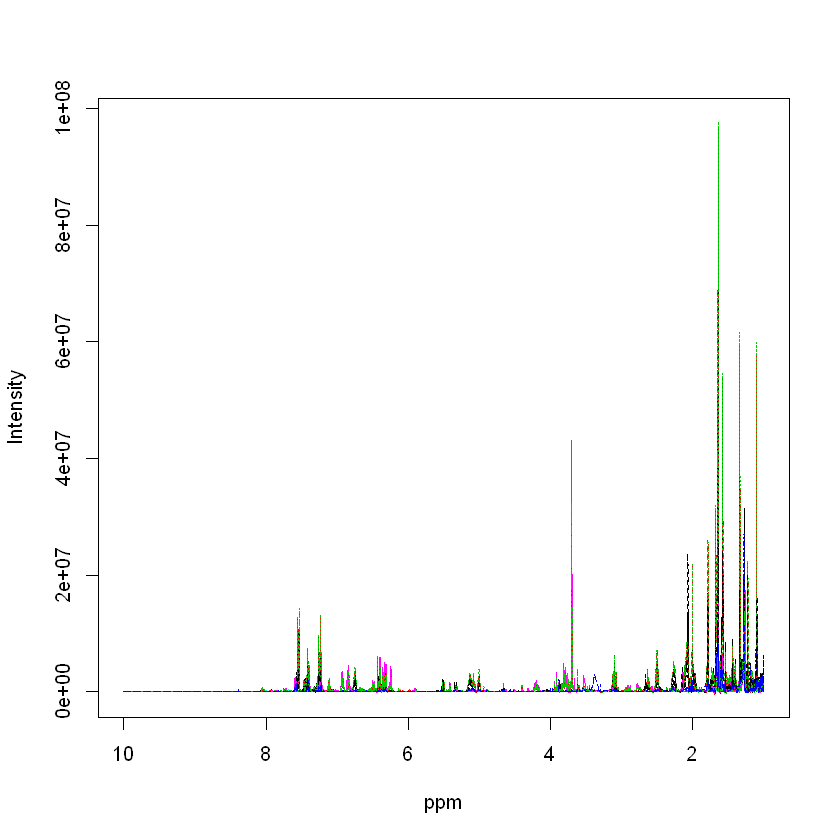

In [10]:
#Visualisation

matspec(ppm.ex, X.pqn[1:10,], shift = c(1,10))

# PCA

iterations: 19
iterations: 49
[1] 115   2
[1] 83970     2


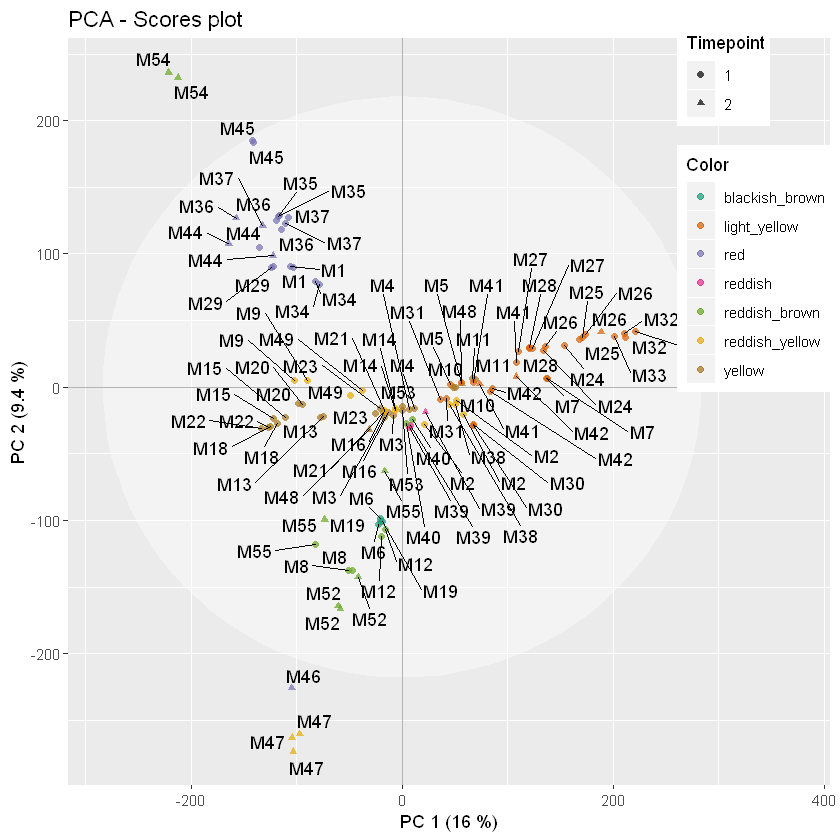

In [11]:
#PCA

ID= Metadata_f$SampleID

pca.model=pca(X=X.pqn, pc=2, scale='UV', center=TRUE)

plotscores(model=pca.model, pc=c(1,2), an=list(Color=Metadata_f$Color,Timepoint=as.character(Metadata_f$Probe),ID=ID), title='PCA - Scores plot')

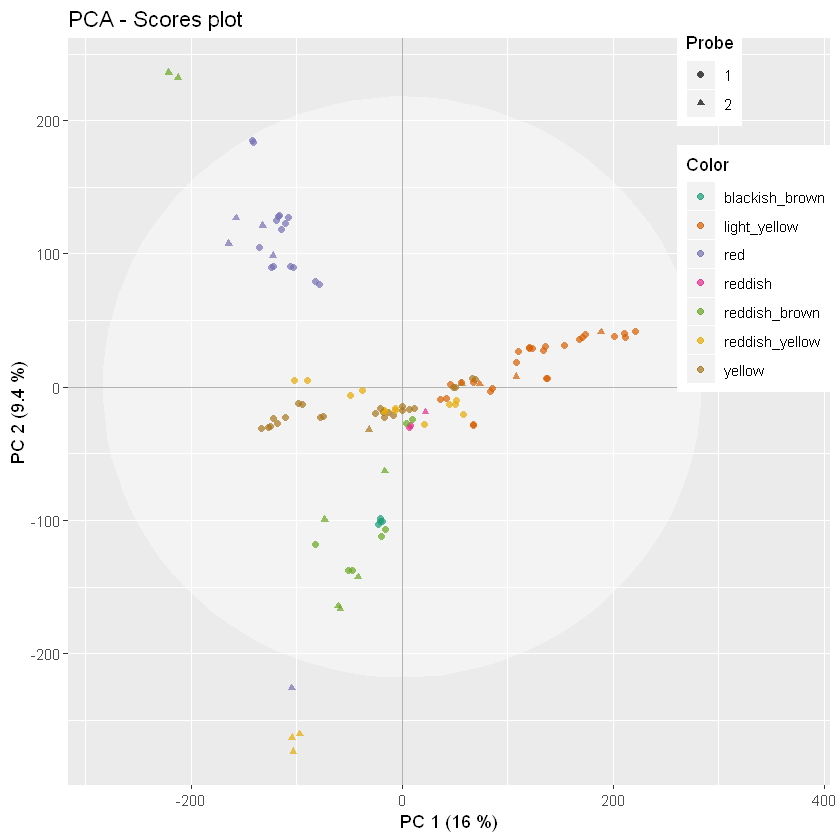

In [12]:
plotscores(model=pca.model, pc=c(1,2), an=list(Color=Metadata_f$Color,Probe=as.character(Metadata_f$Probe)), title='PCA - Scores plot')

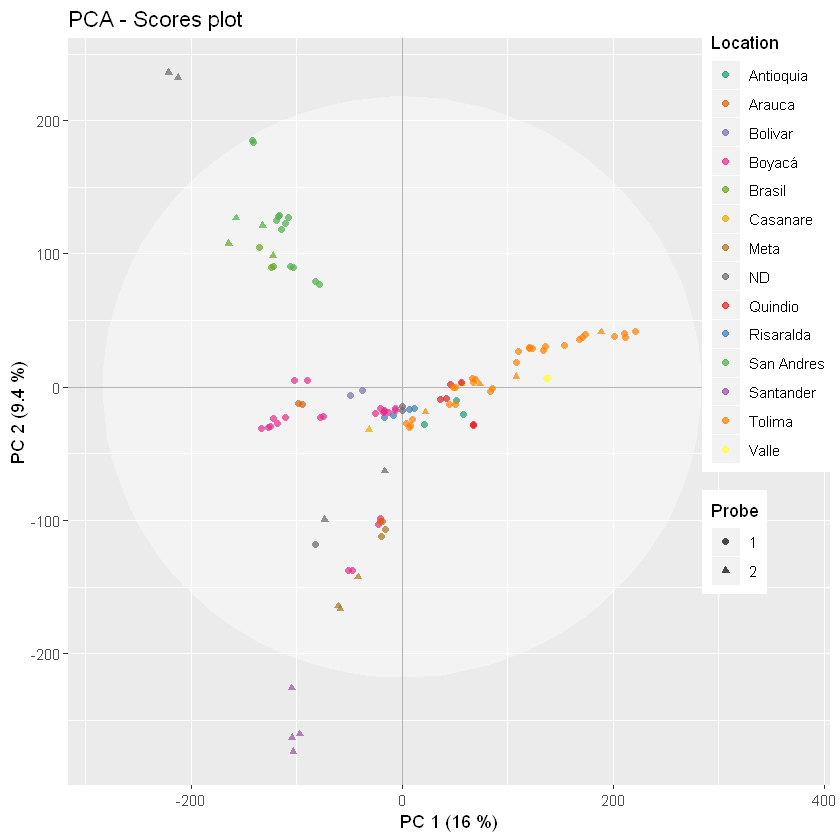

In [13]:
plotscores(model=pca.model, pc=c(1,2), an=list(Location=Metadata_f$Origen,Probe=as.character(Metadata_f$Probe)), title='PCA - Scores plot')

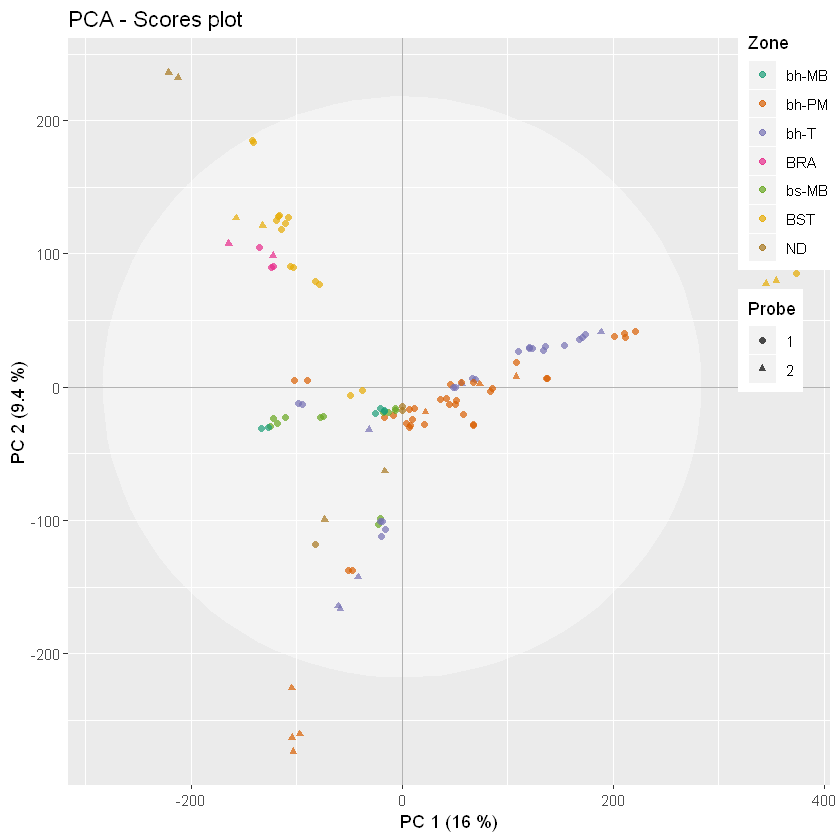

In [14]:
plotscores(model=pca.model, pc=c(1,2), an=list(Zone=Metadata_f$Zona,Probe=as.character(Metadata_f$Probe)), title='PCA - Scores plot')


Warning message in if (grepl("stat|recon", type, ignore.case = T)) {:
"la condición tiene longitud > 1 y sólo el primer elemento será usado"

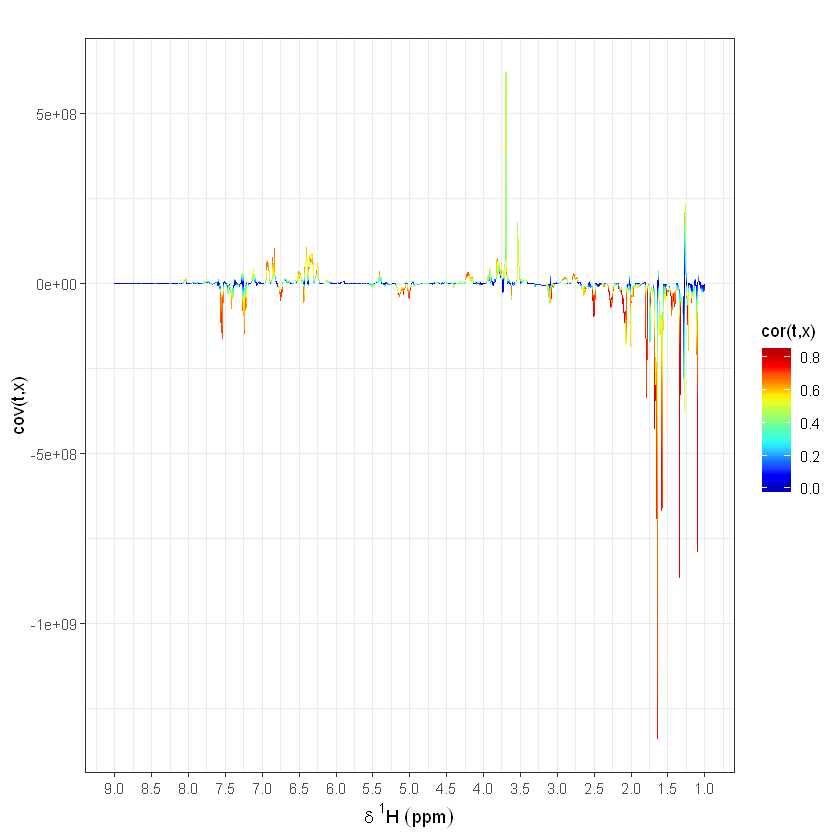

In [15]:
plotload(pca.model, X.pqn, ppm.ex, pc=2, shift=c(1,9))

# OPLS-DA

Preparing data ... done.
Performing OPLS-DA ... [1] 0
done.
A model with 1 predictive and 1 orthogonal component(s) was fitted.



Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font fa

"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds,

"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds,

"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds,

"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds,

"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds,

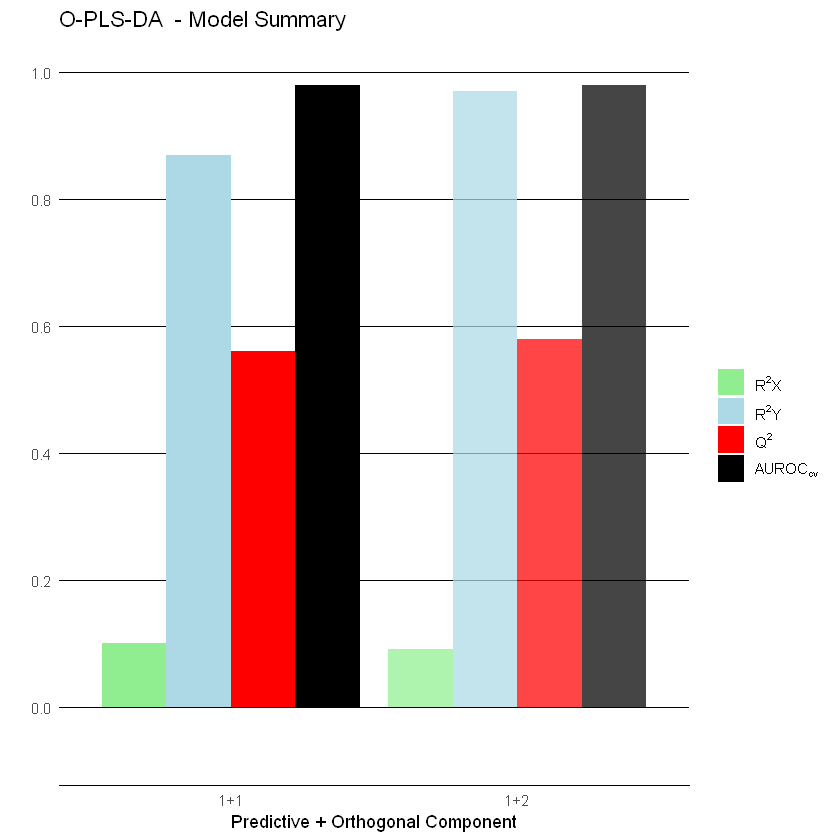

In [16]:
###OPLS con Metabomate

Origen=as.character(Metadata_f$Type2)
propoleo.oplsmet<- MetaboMate::opls(X.pqn,Origen)

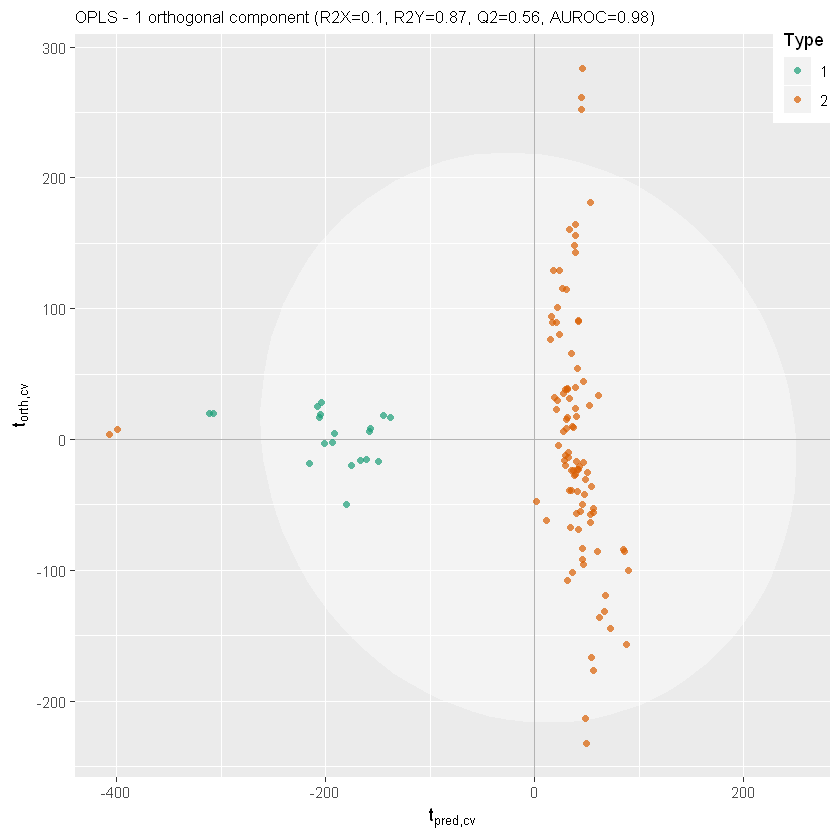

In [17]:
#OPLS Scores plot
plotscores(model=propoleo.oplsmet, pc=c(1,2), an=list(
  Type=Origen),          # colouring according to color type 1:red 2:other
  title='OPLS - Scores plot',     # plot title
  cv.scores = T)                  # visualise cross-validated scores


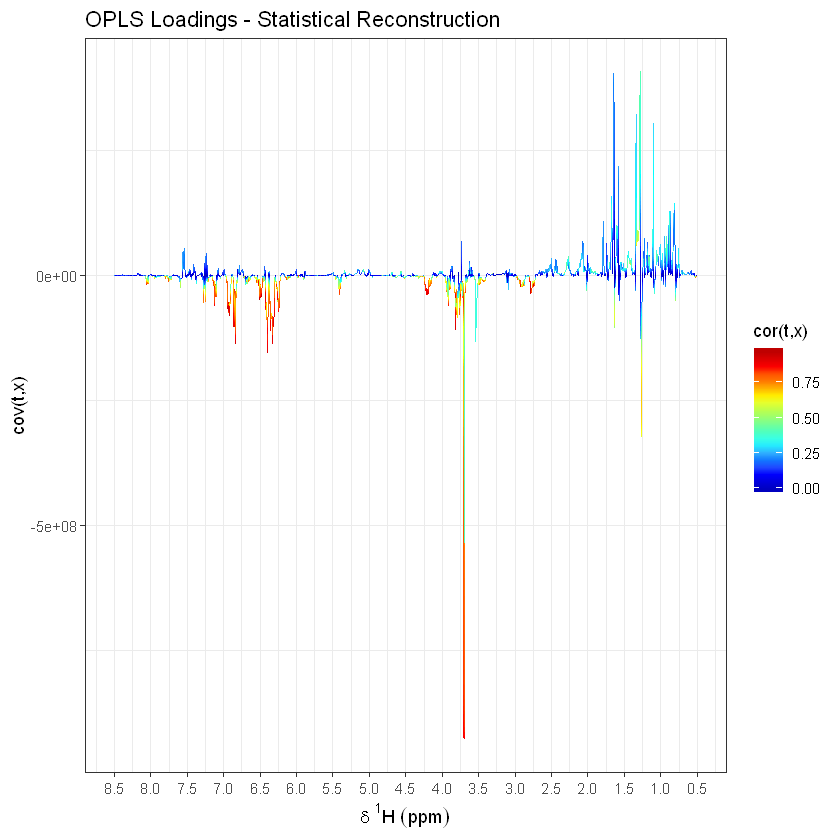

In [30]:
plotload(propoleo.oplsmet, X.pqn, ppm.ex, type='Reconstruction', title = 'OPLS Loadings - Statistical Reconstruction', shift=c(0.5,8.5))

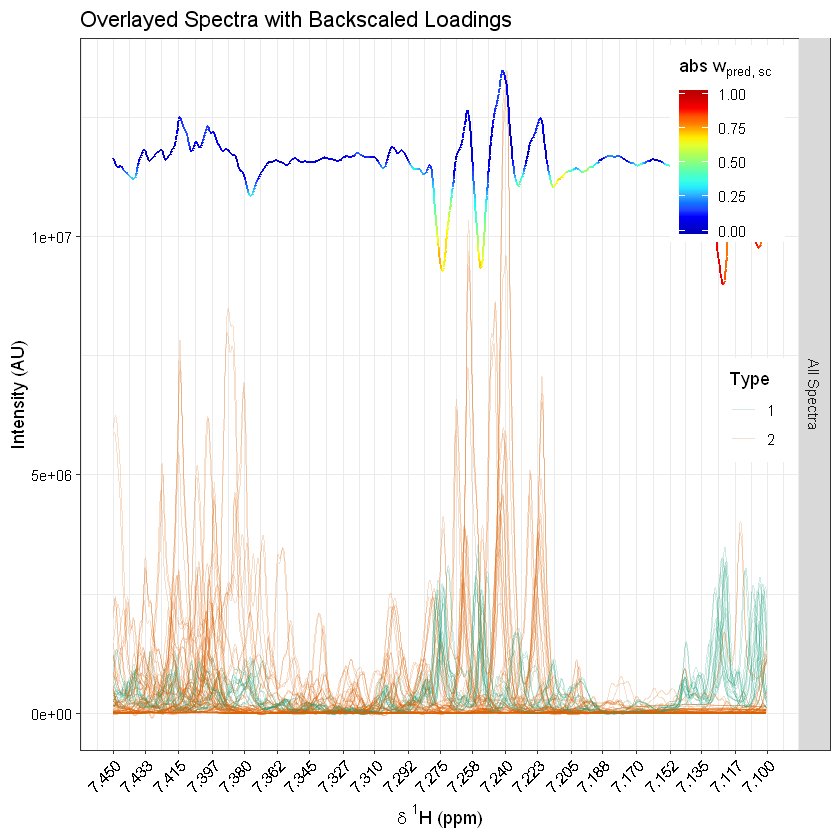

In [18]:
#Overlayed Spectra with Backscaled Loadings
specload1(model=propoleo.oplsmet, X=X.pqn, ppm=ppm.ex, shift=c(7.1,7.45), an=list(
  facet='All Spectra', 
  Type=Origen), 
  type='backscaled', alp = 0.2, title = 'Overlayed Spectra with Backscaled Loadings')

In [19]:
###OPLS con ropls

library(ropls)

propoleo.opls <- ropls::opls(X.pqn,Origen,predI=1,orthoI=NA)

#Training
propoleo.opls1 <- ropls::opls(X.pqn,Origen,predI=1,orthoI=NA, subset="odd")

#Predictions on the training subset

trainVi <- getSubsetVi(propoleo.opls1)
table(Origen[trainVi], fitted(propoleo.opls1))

#Predictions on the test subset

table(Origen[-trainVi],
      predict(propoleo.opls1, X.pqn[-trainVi, ]))


Warning message:
"package 'ropls' was built under R version 3.5.2"
Attaching package: 'ropls'

The following object is masked from 'package:MetaboMate':

    opls



OPLS-DA
115 samples x 83970 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum)  RMSEE pre ort pR2Y  pQ2
Total    0.375    0.996   0.975 0.0247   1   4 0.05 0.05


Warning message:
"'permI' set to 0 because train/test partition is selected"

OPLS-DA
58 samples x 83970 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum)  RMSEE  RMSEP pre ort
Total    0.399    0.997   0.821 0.0207 0.0431   1   4


   
     1  2
  1 10  0
  2  0 48

   
     1  2
  1  9  0
  2  0 48

## Colombian red propolis vs Brazilian red propolis

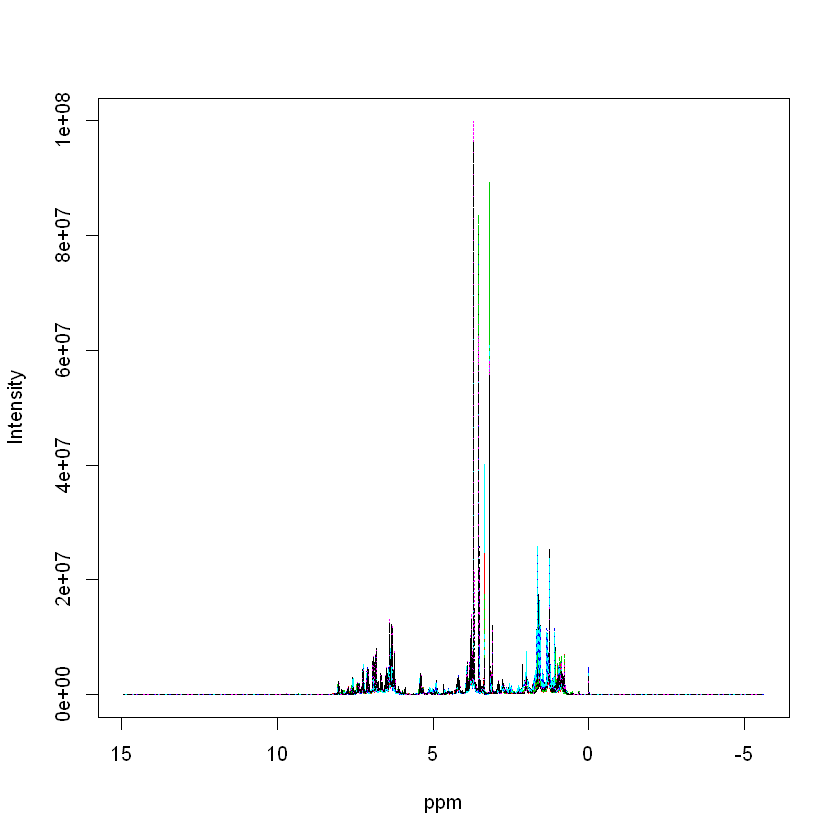

In [20]:
#Data subsetting
red_propolis <- subset(X, Metadata_f$Color=="red")

red_propolis <- red_propolis[c(-1),]

Metadata_red <- subset(Metadata_f, Metadata_f$Color=="red")

Metadata_red <- Metadata_red[c(-1),]

matspec(ppm, red_propolis, shift= range(ppm))

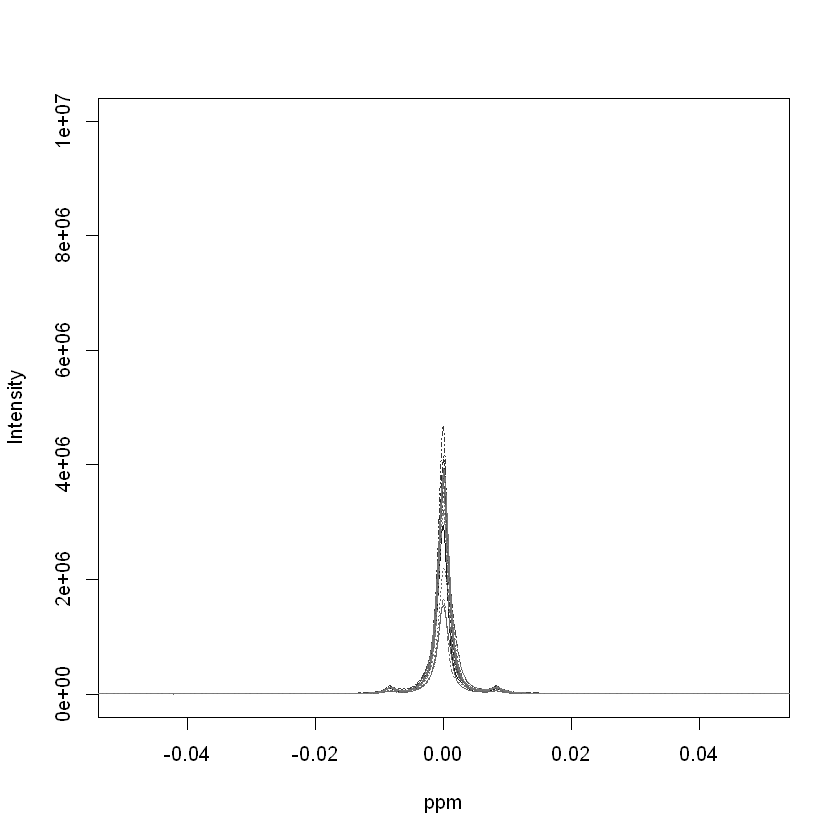

In [21]:
#Calibration

red_propolis.cali = calibration(red_propolis, ppm, type='Urine')

Gray <- gray.colors(20, start=0.1, end=0.5, gamma=2.2, alpha=NULL)

matplot(t(ppm),t(red_propolis.cali), type=("l"), xlim = c(-0.05,0.05), ylim=c(-1e4, 1e7), xlab="ppm", ylab="Intensity", col=Gray)


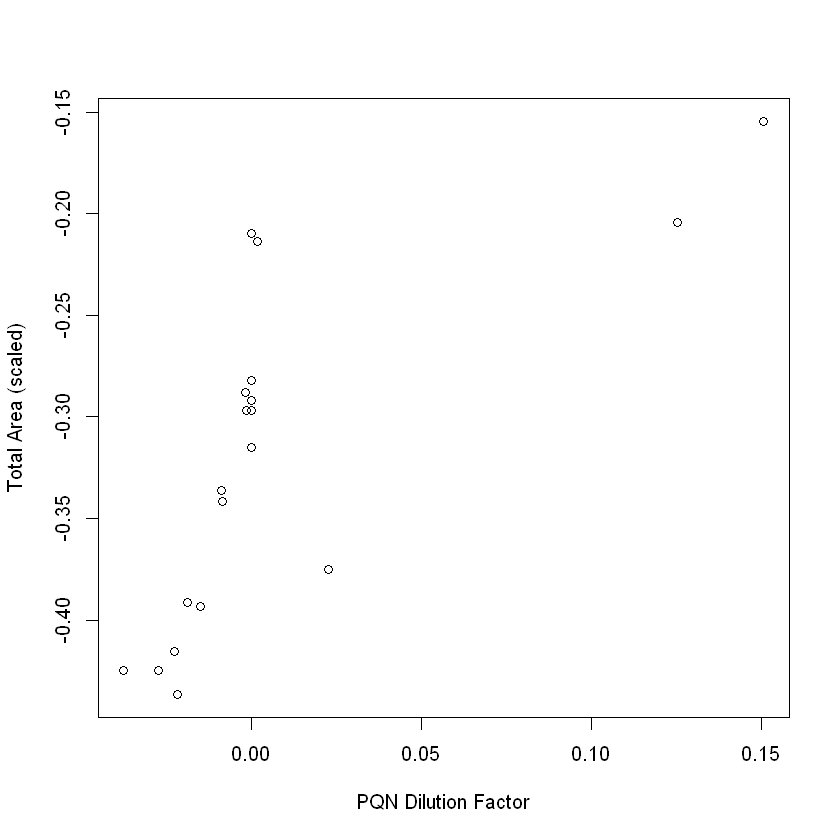

In [22]:
#Excision of undesired regions

red_propolis.cali=red_propolis.cali[,-c(idx.TMS, idx.meoh1, idx.meoh2, idx.meoh3, idx.water, idx.noise)]

#Baseline correction

red_propolis.bl=bline(red_propolis.cali)

#Spectral normalisation

red_propolis.pqn= pqn(red_propolis.bl, add.DilF = 'dilF.pqn')
red_propolis.ta= totalArea(red_propolis.bl, add.DilF = 'dilF.ta')

plot(log10(dilF.pqn), log10(dilF.ta), xlab='PQN Dilution Factor', ylab='Total Area (scaled)')
abline(a = c(0,1), col='red')


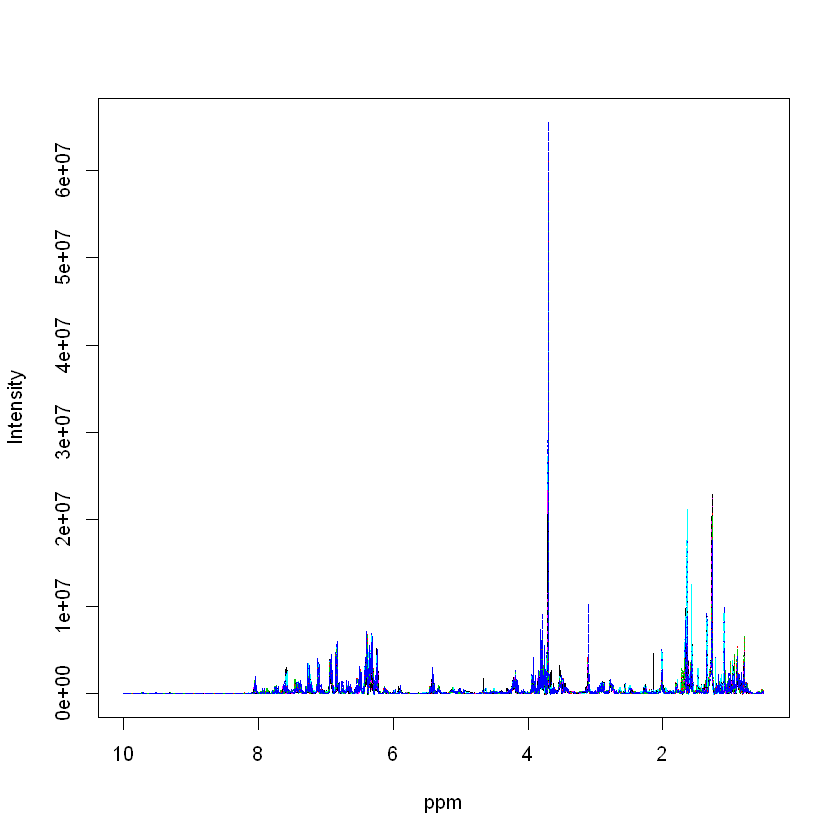

In [23]:
#Visualisation

matspec(ppm.ex, red_propolis.pqn[1:10,], shift = c(0,10))

iterations: 43
iterations: 19
[1] 19  2
[1] 83970     2


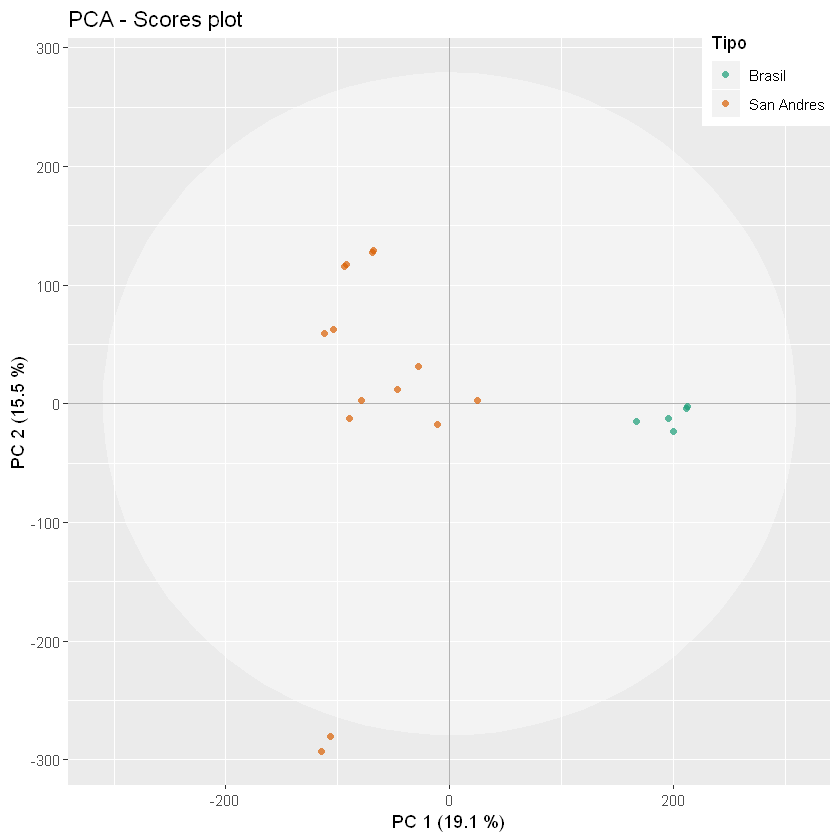

In [24]:
#PCA

pca.model.red=pca(X=red_propolis.pqn, pc=2, scale='UV', center=TRUE)

plotscores(model=pca.model.red, pc=c(1,2), an=list(Tipo=Metadata_red$Origen), title='PCA - Scores plot')

Warning message in if (grepl("stat|recon", type, ignore.case = T)) {:
"la condición tiene longitud > 1 y sólo el primer elemento será usado"

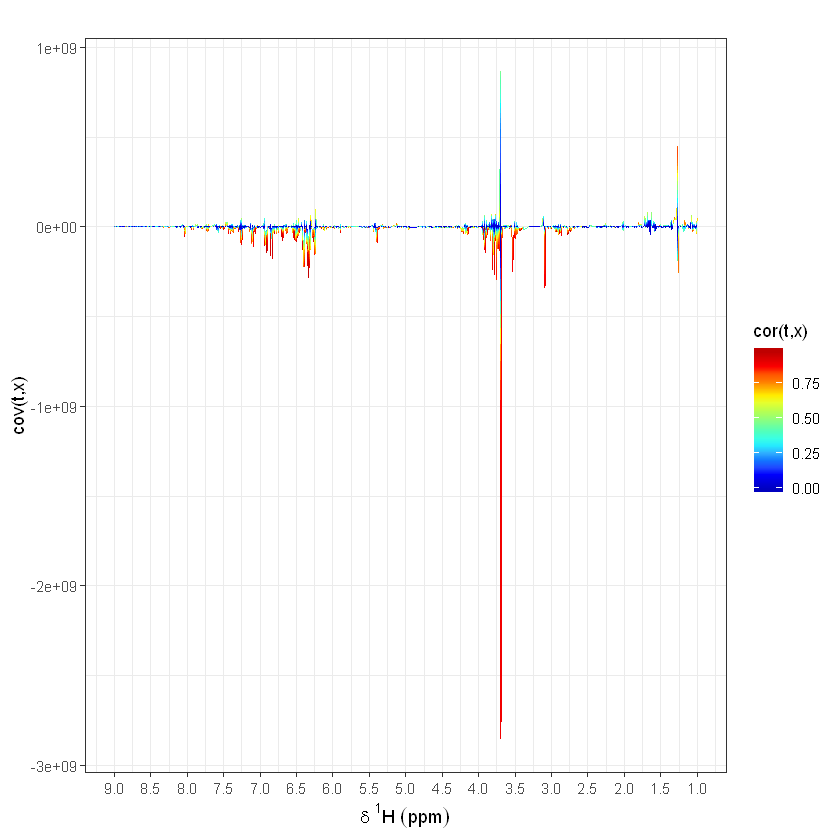

In [25]:
plotload(pca.model.red, red_propolis.pqn, ppm.ex, pc=2, shift=c(1,9))

Warning message in if (grepl("stat|recon", type, ignore.case = T)) {:
"la condición tiene longitud > 1 y sólo el primer elemento será usado"

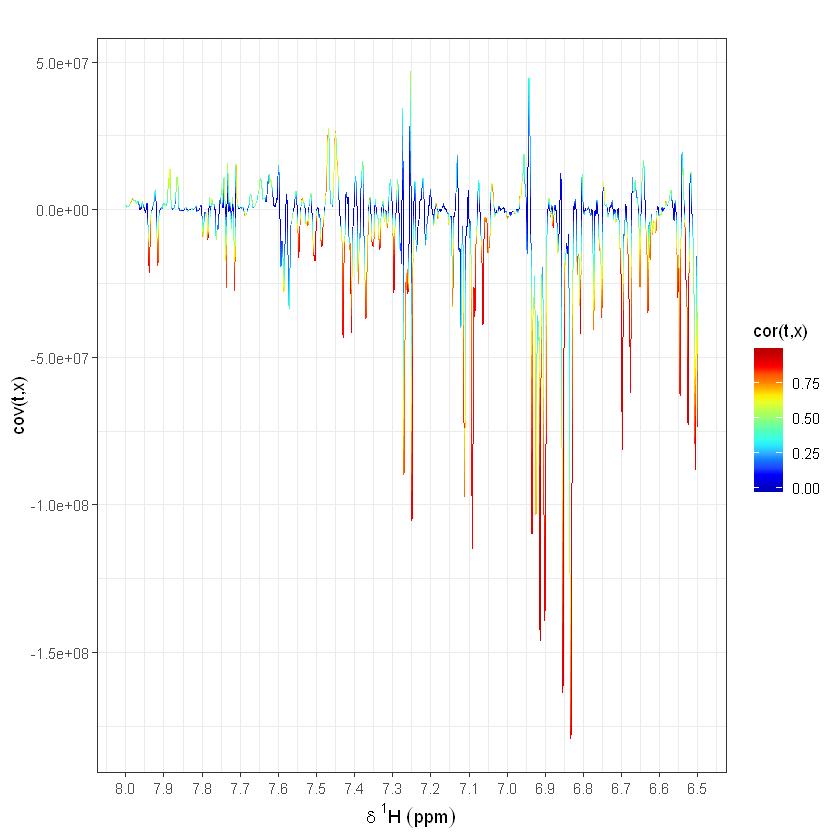

In [26]:
plotload(pca.model.red, red_propolis.pqn, ppm.ex, pc=2, shift=c(6.5,8))

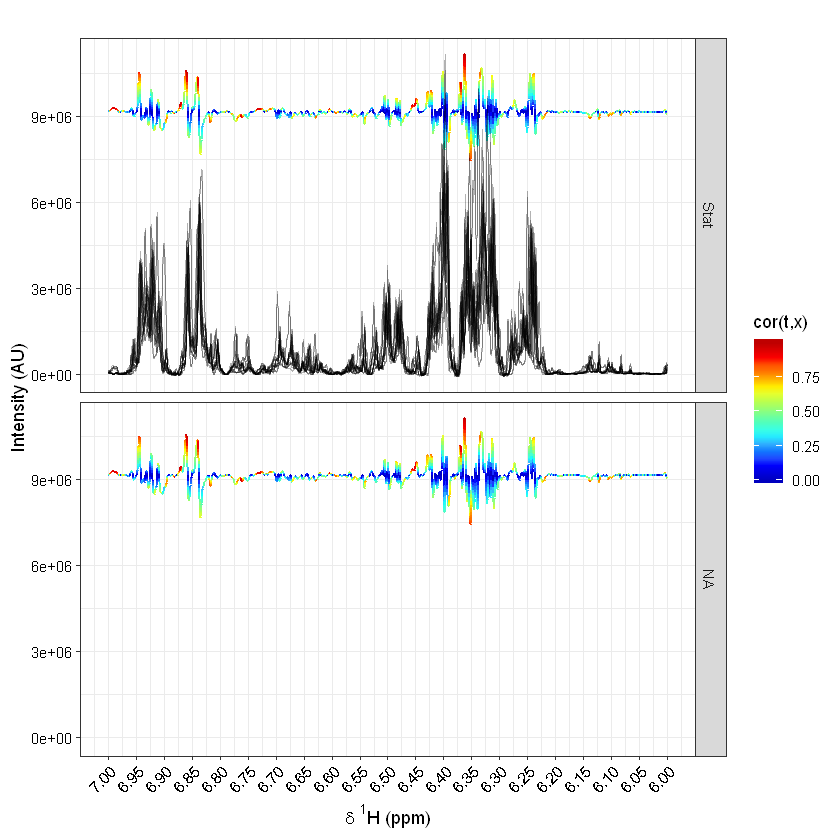

In [27]:
specload(pca.model.red, red_propolis.pqn, ppm.ex, shift=c(6.0,7.0), an= list(type='Stat', alp = 0.2, title = 'Overlayed Spectra with Backscaled Loadings'))

In [28]:
#OPLS

Origen.red= as.character(Metadata_red$Zona)

red.prop.opls <- opls(red_propolis.pqn,Origen.red,predI=1,orthoI=NA)

#Training

red.prop.opls1 <- opls(red_propolis.pqn,Origen.red,predI=1,orthoI=NA, subset="odd")

#Predictions on the training subset

trainVi2 <- getSubsetVi(red.prop.opls1)
table(Origen.red[trainVi2], fitted(red.prop.opls1))

#Predictions on the test subset

table(Origen.red[-trainVi2],
      predict(red.prop.opls1, red_propolis.pqn[-trainVi2, ]))


OPLS-DA
19 samples x 83970 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum)  RMSEE pre ort pR2Y  pQ2
Total    0.264    0.995   0.909 0.0351   1   1 0.05 0.05


Warning message:
"'permI' set to 0 because train/test partition is selected"

OPLS-DA
10 samples x 83970 variables and 1 response
standard scaling of predictors and response(s)
      R2X(cum) R2Y(cum) Q2(cum)  RMSEE RMSEP pre ort
Total    0.324    0.996     0.8 0.0324 0.118   1   1


     
      BRA BST
  BRA   3   0
  BST   0   7

     
      BRA BST
  BRA   2   0
  BST   0   7